# E-Commerce Recommendation System

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Importation of Packages

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Data Importation

In [3]:
import os

# ✅ Define correct base directory
base_dir = r"C:\Users\sammu\Downloads\Recommendation System Project"  # Ensure this is correct

# ✅ Define file paths correctly
events_file = os.path.join(base_dir, "events.csv")
items_part1_file = os.path.join(base_dir, "item_properties_part1.1.csv")
items_part2_file = os.path.join(base_dir, "item_properties_part2.csv")
category_tree_file = os.path.join(base_dir, "category_tree.csv")

# ✅ Ensure all files exist before loading
for file in [events_file, items_part1_file, items_part2_file, category_tree_file]:
    if not os.path.exists(file):
        print(f"❌ Error: File not found -> {file}")
        exit()

# ✅ Define correct data types explicitly
dtypes = {
    "property": "object",
    "timestamp": "int64",
}

# ✅ Function to optimize memory usage
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == "int64":
            df[col] = df[col].astype("int32")
        elif df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
    return df

# ✅ Load large CSV files using Dask
def load_csv_dask(file_path):
    return dd.read_csv(file_path, dtype=dtypes, blocksize="64MB")

# ✅ Load & Process Events Data
events_ddf = load_csv_dask(events_file)
events_ddf["timestamp"] = dd.to_datetime(events_ddf["timestamp"], unit="ms")

# ✅ Load & Process Item Properties Data
items_part1_ddf = load_csv_dask(items_part1_file)
items_part2_ddf = load_csv_dask(items_part2_file)

# ✅ Convert timestamp column in item properties datasets
items_part1_ddf["timestamp"] = dd.to_datetime(items_part1_ddf["timestamp"], unit="ms")
items_part2_ddf["timestamp"] = dd.to_datetime(items_part2_ddf["timestamp"], unit="ms")

# ✅ Merge both item properties datasets
item_properties_ddf = dd.concat([items_part1_ddf, items_part2_ddf])

# ✅ Load & Process Category Tree Data
category_tree_ddf = load_csv_dask(category_tree_file)

# ✅ Convert Dask DataFrames to Pandas for easy analysis
events_df = reduce_memory(events_ddf.compute())
item_properties_df = reduce_memory(item_properties_ddf.compute())
category_tree_df = category_tree_ddf.compute()

print("✅ Data loading complete! Converted to Pandas for easy analysis.")


✅ Data loading complete! Converted to Pandas for easy analysis.


## Exploratory Data Analysis

### 1. Data Validation and Sanity Checks

### Events Data

In [7]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [8]:
events_df.tail()

,timestamp,visitorid,event,itemid,transactionid
2756096,2015-08-01 03:13:05.939,591435,view,261427,NaN
2756097,2015-08-01 03:30:13.142,762376,view,115946,NaN
2756098,2015-08-01 02:57:00.527,1251746,view,78144,NaN
2756099,2015-08-01 03:08:50.703,1184451,view,283392,NaN
2756100,2015-08-01 03:36:03.914,199536,view,152913,NaN


In [9]:
events_df.shape

(2756101, 5)

In [10]:
events_df.isna().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [11]:
# Percentage of null values in events data
print("\n3. Percentage of Null Values per Column:")
print((events_df.isnull().sum() / events_df.shape[0]) * 100)


3. Percentage of Null Values per Column:
timestamp         0.00000
visitorid         0.00000
event             0.00000
itemid            0.00000
transactionid    99.18519
dtype: float64


There are no missing values in the timestamp, visitorid, event and itemid except transactionid, which has 2,733,644 missing values. This is because, once an individual just views or adds to cart without making a transaction, he or she will not get a transaction id.

In [13]:
# handling missing values in the transactionid column.
# Fill missing transaction IDs with 0 (assuming NaN means no purchase)
#events_df["transactionid"] = events_df["transactionid"].fillna(0)

In [14]:
# checking for missing values in event data after handling missing values in the transactionid column.
#events_df.isna().sum()

There is no missing values in the events data.

In [16]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int32         
 2   event          object        
 3   itemid         int32         
 4   transactionid  float32       
dtypes: datetime64[ns](1), float32(1), int32(2), object(1)
memory usage: 73.6+ MB


In [17]:
events_df.describe()

,timestamp,visitorid,itemid,transactionid
count,2756101,2.756101e+06,2.756101e+06,22457.000000
mean,2015-07-09 06:48:08.348103680,7.019229e+05,2.349225e+05,8826.499023
min,2015-05-03 03:00:04.384000,0.000000e+00,3.000000e+00,0.000000
25%,2015-06-05 04:23:14.792000,3.505660e+05,1.181200e+05,4411.000000
50%,2015-07-09 14:43:33.599000064,7.020600e+05,2.360670e+05,8813.000000
75%,2015-08-10 16:45:05.168000,1.053437e+06,3.507150e+05,13224.000000
max,2015-09-18 02:59:47.788000,1.407579e+06,4.668670e+05,17671.000000
std,NaN,4.056875e+05,1.341954e+05,5098.998047


In [18]:
# Unique values in each column
print("\n Unique Value Counts per Column:")
for col_name in events_df.columns:
    unique_vals = events_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")


 Unique Value Counts per Column:
  timestamp: 2750455
  visitorid: 1407580
  event: 3
  itemid: 235061
  transactionid: 17672


In [19]:
# checking for duplicates in events data
events_df.duplicated().sum()

460

In [20]:
# dropping duplicate values
events_df.drop_duplicates(inplace=True)

In [21]:
events_df.duplicated().sum()

0

In [22]:
events_df['visitorid'].value_counts()

visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
           ... 
578031        1
643534        1
698825        1
843029        1
1184451       1
Name: count, Length: 1407580, dtype: int64

visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
Name: count, dtype: int64


Text(0, 0.5, 'number of event')

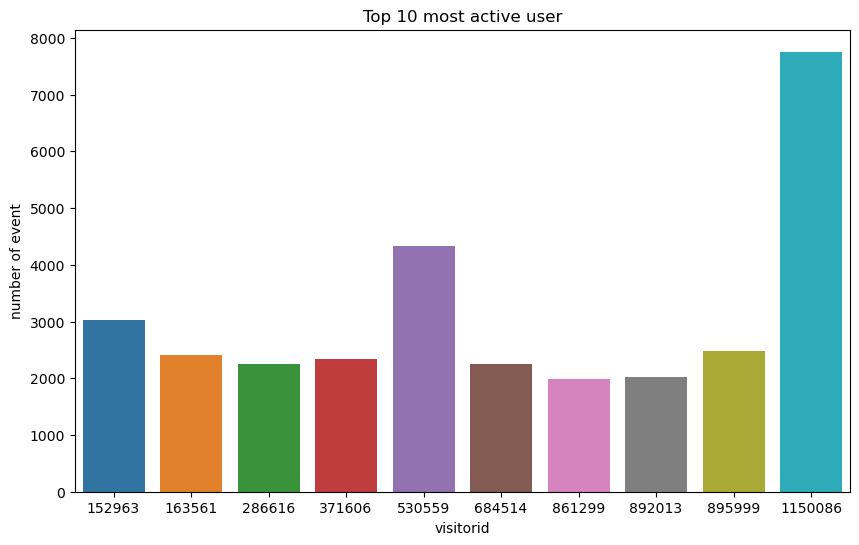

In [23]:
#most Active users
top_most_active_user=events_df['visitorid'].value_counts().head(10)
print(top_most_active_user)
plt.figure(figsize=(10,6))

top_most_active_user_sort = top_most_active_user.sort_values(ascending=False)

sns.barplot(x=top_most_active_user_sort.index,y=top_most_active_user_sort.values)
plt.title('Top 10 most active user')
plt.xlabel('visitorid')
plt.ylabel('number of event')

In [24]:
events_counts = events_df['event'].value_counts()
events_counts

event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64

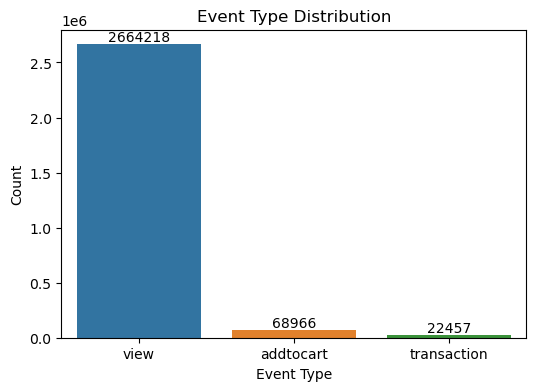

In [25]:
# visualizing events column using countplot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="event", data=events_df, order=events_counts.index)

# Add count labels
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()),
            ha='center', va='bottom', fontsize=10)

plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

In [26]:
# Group by visitorid to see how many events each user performed
user_events_counts = events_df.groupby('visitorid')['event'].count()
user_events_counts.head(10)

visitorid
0    3
1    1
2    8
3    1
4    1
5    1
6    6
7    3
8    1
9    1
Name: event, dtype: int64

In [27]:
events_df['itemid'].value_counts()

itemid
187946    3412
461686    2975
5411      2334
370653    1854
219512    1800
          ... 
145333       1
113185       1
109819       1
302190       1
177353       1
Name: count, Length: 235061, dtype: int64

### Sanity checks for the item_properties data

In [29]:
# Sanity checks for the item_properties data
item_properties_df.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


In [30]:
item_properties_df.tail()

,timestamp,itemid,property,value
1545977,2015-06-07 03:00:00,236931,929,n12.000
1545978,2015-08-30 03:00:00,455746,6,150169 639134
1545979,2015-08-16 03:00:00,347565,686,610834
1545980,2015-06-07 03:00:00,287231,867,769062
1545981,2015-09-13 03:00:00,275768,888,888666 n10800.000 746840 1318567


In [31]:
item_properties_df.shape

(20275902, 4)

In [32]:
# checking for duplicated values
item_properties_df.duplicated().sum()

0

In [33]:
# checking for missing values
item_properties_df.isna().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

In [34]:
# Percentage of null Item_properties
print("\n3. Percentage of Null Values per Column:")
print((item_properties_df.isnull().sum() / item_properties_df.shape[0]) * 100)


3. Percentage of Null Values per Column:
timestamp    0.0
itemid       0.0
property     0.0
value        0.0
dtype: float64


There are no missing values in the item_properties

In [36]:
item_properties_df.describe()

,timestamp,itemid
count,20275902,2.027590e+07
mean,2015-06-24 14:42:23.682880256,2.333904e+05
min,2015-05-10 03:00:00,0.000000e+00
25%,2015-05-24 03:00:00,1.165160e+05
50%,2015-06-07 03:00:00,2.334830e+05
75%,2015-07-26 03:00:00,3.503040e+05
max,2015-09-13 03:00:00,4.668660e+05
std,NaN,1.348452e+05


In [37]:
item_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 1545981
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     int32         
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 696.1+ MB


In [38]:
item_properties_df['itemid'].value_counts()

itemid
158903    468
254069    462
91855     461
150800    459
120386    444
         ... 
251894     15
342400     14
73456      13
207227     12
243157     12
Name: count, Length: 417053, dtype: int64

In [39]:
print("*** Top 10 Most Frequent Properties***")
item_properties_df['property'].value_counts().sort_values(ascending=False).head(10)

*** Top 10 Most Frequent Properties***


property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
283            597419
776            574220
678            481966
364            476486
202            448938
Name: count, dtype: int64

In [40]:
# Unique values in each Item_properties column
print("\n Unique Value Counts per Column:")
for col_name in item_properties_df.columns:
    unique_vals = item_properties_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")


 Unique Value Counts per Column:
  timestamp: 18
  itemid: 417053
  property: 1104
  value: 1966868


In [41]:
# Count how many properties each item has
item_properties_counts = item_properties_df.groupby('itemid')['property'].count()
print(item_properties_counts.head())
print("\n")
print("*** Distribution of 'property' count per item ***")
print(item_properties_counts.describe())

itemid
0    45
1    86
2    24
3    46
4    42
Name: property, dtype: int64


*** Distribution of 'property' count per item ***
count    417053.000000
mean         48.617087
std          27.385722
min          12.000000
25%          28.000000
50%          42.000000
75%          60.000000
max         468.000000
Name: property, dtype: float64


In [42]:
print("\nTop 10 value:")
item_properties_df['value'].value_counts().sort_values(ascending=False).head(10)


Top 10 value:


value
769062                                 1537247
0                                       863246
1                                       641420
679677                                  417054
1285872                                 417053
519769                                  417053
1116693                                 157243
1297729 n156.000 606827                 120136
664227                                  118653
664227 1305534 664227 463202 664227      96245
Name: count, dtype: int64

<Axes: xlabel='timestamp'>

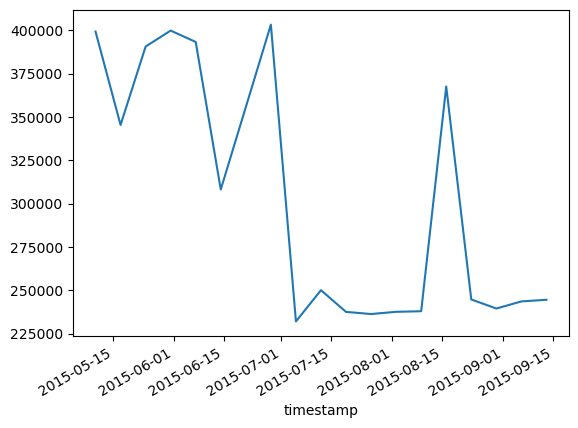

In [43]:
item_properties_df.groupby("timestamp")["itemid"].nunique().plot(kind="line")

In [44]:
item_properties_df["itemid"].value_counts().head(20)

itemid
158903    468
254069    462
91855     461
150800    459
120386    444
339536    444
270097    443
373096    428
162893    428
431708    428
89590     427
113473    427
300084    427
137508    427
358373    426
177032    418
83002     418
145680    418
288797    410
147197    410
Name: count, dtype: int64

<Axes: xlabel='timestamp'>

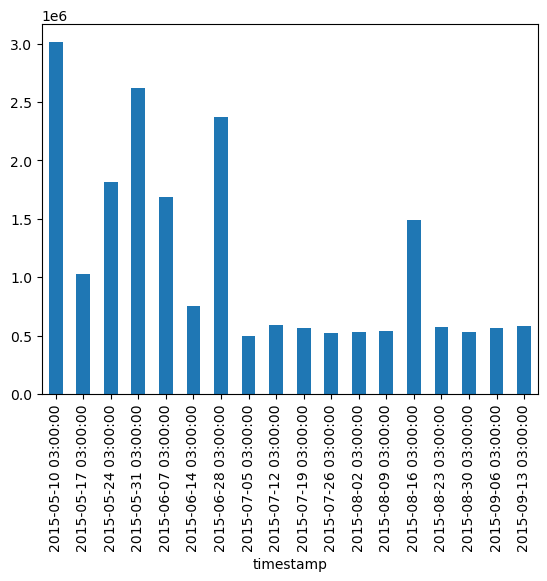

In [45]:
item_properties_df["timestamp"].value_counts().sort_index().plot(kind="bar")

In [46]:
item_properties_df["timestamp"].value_counts().sort_index()

timestamp
2015-05-10 03:00:00    3012756
2015-05-17 03:00:00    1027889
2015-05-24 03:00:00    1815598
2015-05-31 03:00:00    2620101
2015-06-07 03:00:00    1686681
2015-06-14 03:00:00     755965
2015-06-28 03:00:00    2368972
2015-07-05 03:00:00     497785
2015-07-12 03:00:00     593657
2015-07-19 03:00:00     563575
2015-07-26 03:00:00     519460
2015-08-02 03:00:00     529315
2015-08-09 03:00:00     542778
2015-08-16 03:00:00    1488244
2015-08-23 03:00:00     571339
2015-08-30 03:00:00     532586
2015-09-06 03:00:00     566183
2015-09-13 03:00:00     583018
Name: count, dtype: int64

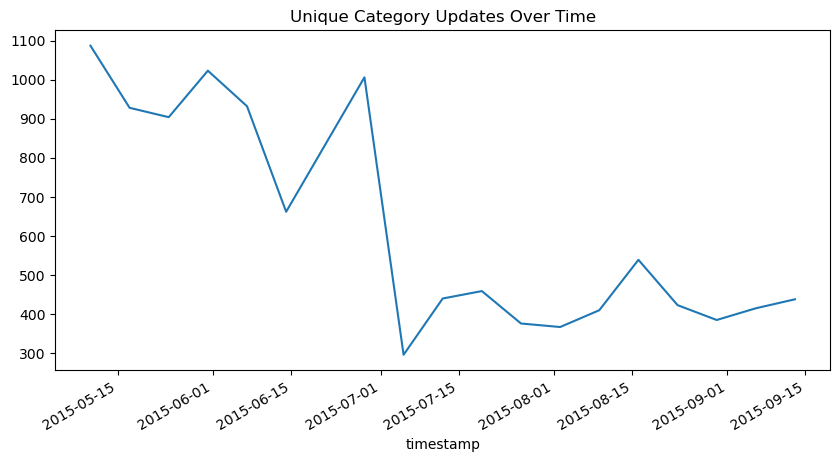

In [47]:
category_trend = item_properties_df[item_properties_df['property'] == 'categoryid']
category_trend.groupby('timestamp')['value'].nunique().plot(kind='line', figsize=(10, 5))
plt.title("Unique Category Updates Over Time")
plt.show()

In [48]:
item_properties_df_copy = item_properties_df.copy()

In [49]:
# Keep only the latest property update per item
#item_properties_df_copy = item_properties_df_copy.drop_duplicates(subset=['itemid', 'property'], keep='last')


In [50]:
item_properties_df_copy.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


In [51]:
item_properties_df_copy.tail()

,timestamp,itemid,property,value
1545977,2015-06-07 03:00:00,236931,929,n12.000
1545978,2015-08-30 03:00:00,455746,6,150169 639134
1545979,2015-08-16 03:00:00,347565,686,610834
1545980,2015-06-07 03:00:00,287231,867,769062
1545981,2015-09-13 03:00:00,275768,888,888666 n10800.000 746840 1318567


In [52]:
item_properties_df_copy.shape

(20275902, 4)

In [53]:
# Unique values in each Item_properties column
print("\n Unique Value Counts per Column:")
for col_name in item_properties_df_copy.columns:
    unique_vals = item_properties_df_copy[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")


 Unique Value Counts per Column:
  timestamp: 18
  itemid: 417053
  property: 1104
  value: 1966868


In [54]:
# Sort data by timestamp and item_id
item_properties_df_copy = item_properties_df_copy.sort_values(by=['itemid', 'timestamp'])

In [55]:
item_properties_df_copy.head(20)

,timestamp,itemid,property,value
484093,2015-05-10 03:00:00,0,283,66094 372274 478989
1031883,2015-05-10 03:00:00,0,6,1152934 1238769
1162784,2015-05-10 03:00:00,0,159,519769
1528507,2015-05-10 03:00:00,0,678,372274
431791,2015-05-10 03:00:00,0,790,n91200.000
491064,2015-05-10 03:00:00,0,categoryid,209
47207,2015-05-17 03:00:00,0,225,1301326
669106,2015-05-17 03:00:00,0,6,1152934 1238769
1205788,2015-05-17 03:00:00,0,available,0
427470,2015-05-17 03:00:00,0,698,1152934 1238769


In [56]:
# Check if any item is missing categoryid or available properties
missing_category = item_properties_df[item_properties_df['property'] == 'categoryid']['itemid'].nunique()
missing_available = item_properties_df[item_properties_df['property'] == 'available']['itemid'].nunique()

print(f"Items with categoryid: {missing_category}")
print(f"Items with available: {missing_available}")

Items with categoryid: 417053
Items with available: 417053


In [57]:
# Check if any item is missing categoryid or available properties
missing_category = item_properties_df_copy[item_properties_df_copy['property'] == 'categoryid']['itemid'].nunique()
missing_available = item_properties_df_copy[item_properties_df_copy['property'] == 'available']['itemid'].nunique()

print(f"Items with categoryid: {missing_category}")
print(f"Items with available: {missing_available}")

Items with categoryid: 417053
Items with available: 417053


Top 10 properties that change the most:
property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
283            597419
776            574220
678            481966
364            476486
202            448938
Name: itemid, dtype: int64


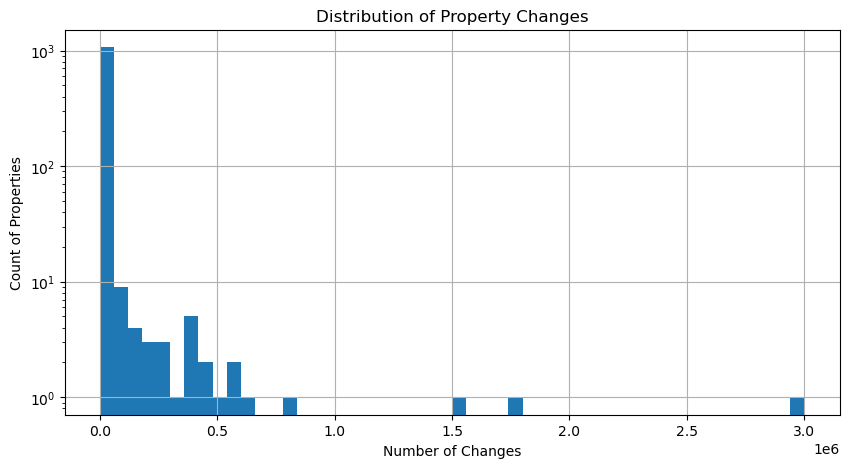

Number of static properties: dd.Scalar<series-..., dtype=int64>
Percentage of properties that remain constant: dd.Scalar<mul-e80..., dtype=float64>%
Number of items with changing category IDs: 23352
Number of items that changed availability: 67001


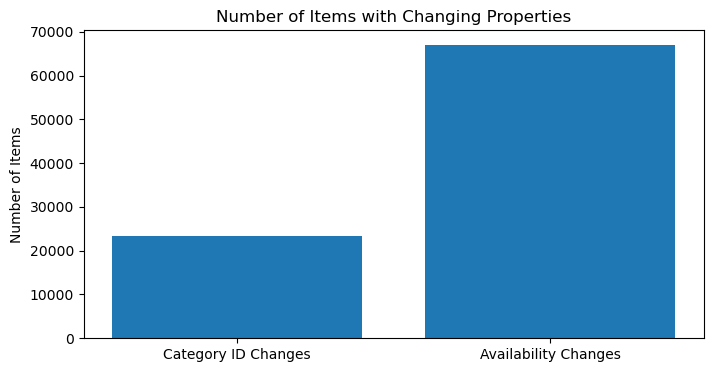

In [58]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# Load your Dask DataFrame (assuming 'ddf' is already loaded)
# ddf = dd.read_csv("item_properties.csv")  # Uncomment if needed

### Count How Many Times Each Property Changes
property_change_counts = item_properties_ddf.groupby("property")["itemid"].count().compute()

# Sort and display top 10 changing properties
print("Top 10 properties that change the most:")
print(property_change_counts.sort_values(ascending=False).head(10))

# Plot distribution
plt.figure(figsize=(10, 5))
property_change_counts.hist(bins=50, log=True)  # Log scale due to high variance
plt.xlabel("Number of Changes")
plt.ylabel("Count of Properties")
plt.title("Distribution of Property Changes")
plt.show()


###  Identify Properties That Rarely Change ###
# Count unique (itemid, property) pairs
unique_properties = item_properties_ddf.groupby(["property", "itemid"]).size().reset_index()
# Rename the '0' column to 'count'
unique_properties = unique_properties.rename(columns={0: 'count'})

# Properties that have only one entry per item
static_properties = unique_properties[unique_properties["count"] == 1]["property"].nunique()
print(f"Number of static properties: {static_properties}")

# Percentage of static properties
total_properties = unique_properties["property"].nunique()
percentage_static = (static_properties / total_properties) * 100
print(f"Percentage of properties that remain constant: {percentage_static:}%")


###  Check How Many Items Have Changing Category IDs ###
# Filter categoryid changes
category_changes = item_properties_ddf[item_properties_ddf["property"] == "categoryid"].groupby("itemid")["value"].nunique().compute()

# Get number of items with changing categoryid
changing_category_items = (category_changes > 1).sum()
print(f"Number of items with changing category IDs: {changing_category_items}")


### Check How Many Items Have Changing Availability (Stock Status) ###
availability_changes = item_properties_ddf[item_properties_ddf["property"] == "available"].groupby("itemid")["value"].nunique().compute()

# Count how many items changed availability at least once
changing_availability_items = (availability_changes > 1).sum()
print(f"Number of items that changed availability: {changing_availability_items}")

# Plot category ID and availability changes
plt.figure(figsize=(8, 4))
plt.bar(["Category ID Changes", "Availability Changes"], [changing_category_items, changing_availability_items])
plt.ylabel("Number of Items")
plt.title("Number of Items with Changing Properties")
plt.show()

1. 23,352 items changed category IDs

This is unexpected because an item should not frequently switch categories.
Possible reasons:
Data errors: Mistakes in recording or merging category information.

Reclassification: The system restructured its category taxonomy over time.

Genuine shifts: Some items (e.g., multipurpose products) may be reassigned to different categories.


2. 67,001 items changed availability

This is expected since stock fluctuates over time.
Frequent availability changes mean:
The inventory system updates data regularly.
Many items go out of stock and come back, which affects recommendations.

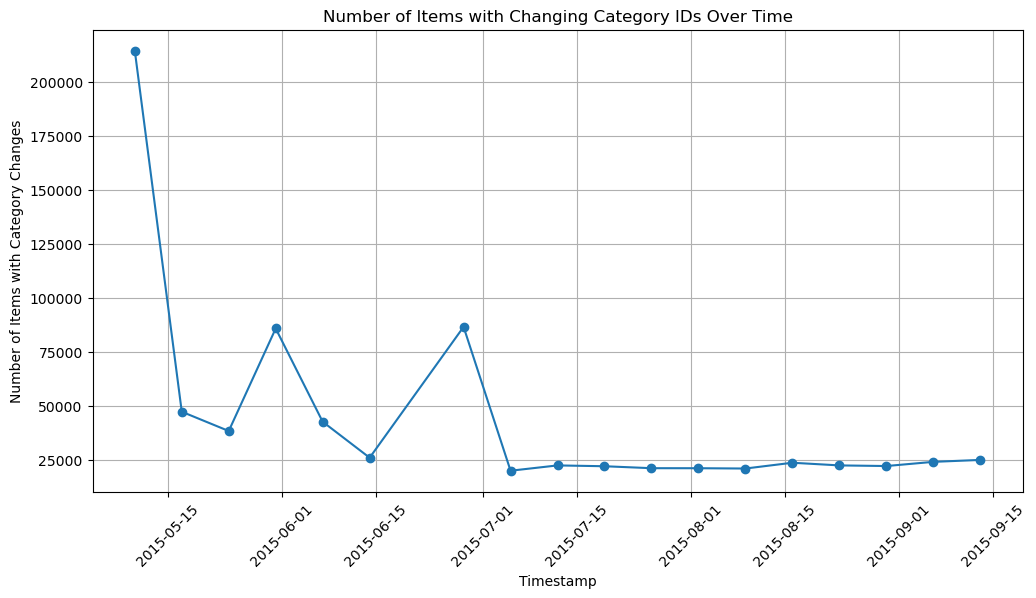

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `ddf` is your item properties dataframe
# Convert timestamp column to datetime
ddf = item_properties_ddf

# Filter for category ID changes
category_changes = ddf[ddf['property'] == 'categoryid']

# Count number of unique items that changed category per timestamp
category_changes_count = category_changes.groupby('timestamp')['itemid'].nunique().compute() # Compute the result immediately

# Plot
plt.figure(figsize=(12, 6))
plt.plot(category_changes_count.index, category_changes_count.values, marker='o', linestyle='-')
plt.xlabel("Timestamp")
plt.ylabel("Number of Items with Category Changes")
plt.title("Number of Items with Changing Category IDs Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This plot shows the number of items whose category IDs changed over time. The sharp decline suggests that category changes were frequent in the early timestamps but stabilized over time.

Interpretation:

Early spikes: Many items had their categories adjusted initially, possibly due to reclassification or data corrections.

Gradual stabilization: Over time, fewer items experienced category changes, indicating a more stable categorization system.

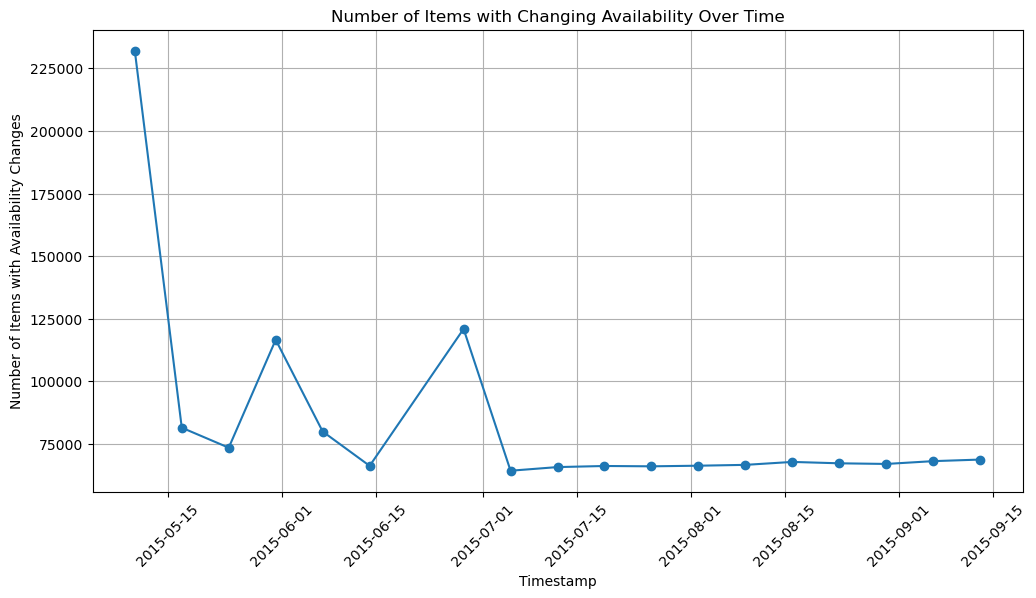

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `ddf` is your item properties dataframe
# Convert timestamp column to datetime
ddf = item_properties_ddf

# Filter for availability changes
availability_changes = ddf[ddf['property'] == 'available']  # Changed 'property' to 'available'

# Count number of unique items that changed availability per timestamp
availability_changes_count = availability_changes.groupby('timestamp')['itemid'].nunique().compute() # Compute the result immediately

# Plot
plt.figure(figsize=(12, 6))
plt.plot(availability_changes_count.index, availability_changes_count.values, marker='o', linestyle='-')
plt.xlabel("Timestamp")
plt.ylabel("Number of Items with Availability Changes")  # Changed y-axis label
plt.title("Number of Items with Changing Availability Over Time")  # Changed title
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This plot shows the number of items with availability changes over time. Similar to the category ID changes, availability fluctuations were much higher in the early periods and then stabilized.

Interpretation:

Early fluctuations: Many items were frequently changing availability at the start. This could be due to:

Inventory updates

Data corrections

System changes affecting availability tracking

Gradual stabilization: As time progressed, fewer items experienced availability changes, suggesting:

The inventory became more stable

The system tracked availability more consistently

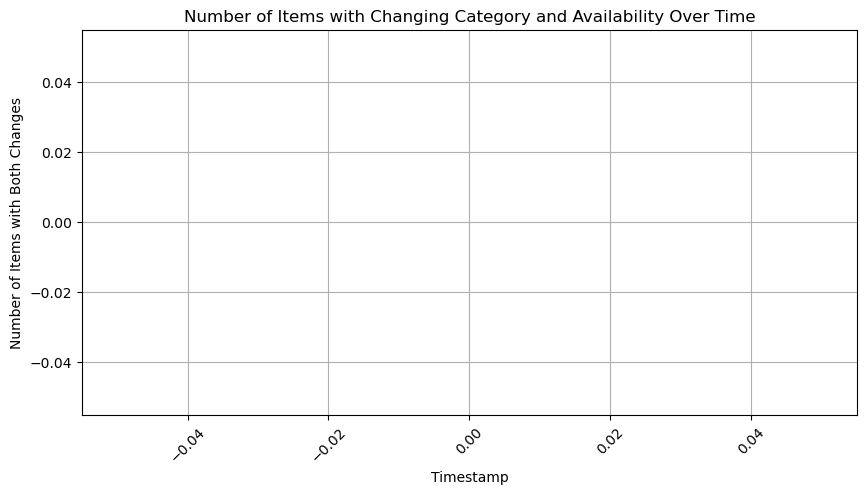

In [64]:
import matplotlib.pyplot as plt

# Find items that changed both category and availability
items_both_changes = set(category_changes) & set(availability_changes)

# Filter data for these items
df_both_changes = ddf[ddf['itemid'].isin(items_both_changes)]

# Count number of affected items per timestamp
items_both_over_time = df_both_changes.groupby('timestamp')['itemid'].nunique().compute() #Added compute()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(items_both_over_time.index, items_both_over_time.values, marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Number of Items with Both Changes')
plt.title('Number of Items with Changing Category and Availability Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [65]:
# Extract categoryid and available
category_df = ddf[ddf["property"] == "categoryid"][["itemid", "timestamp", "value"]].rename(columns={"value": "categoryid"})
available_df = ddf[ddf["property"] == "available"][["itemid", "timestamp", "value"]].rename(columns={"value": "available"})

# Convert values to numeric
category_df["categoryid"] = category_df["categoryid"].astype(int)
available_df["available"] = available_df["available"].astype(int)

# Merge back to item_props_df so that each row retains its corresponding timestamp-based value
item_props_df = ddf.merge(category_df, on=["itemid", "timestamp"], how="left")
item_props_df = item_props_df.merge(available_df, on=["itemid", "timestamp"], how="left")

# Now forward-fill, but only within the same item_id and within the same time order
# item_props_df = item_props_df.groupby("itemid").apply(lambda x: x.sort_values("timestamp").ffill())

# Drop rows where property is "categoryid" or "available" (since their values are now separate)
item_props_df1 = ddf[~ddf["property"].isin(["categoryid", "available"])]

# Ensure 'categoryid' and 'available' are in item_props_df before merging
item_props_df = item_props_df[["itemid", "categoryid", "available"]].drop_duplicates()

# Merge back categoryid and available (ensuring correct values per item_id)
final_item_df = item_props_df1.merge(
    item_props_df,
    on="itemid", how="left"
)

print(final_item_df.head())

            timestamp  itemid property                            value  \
0 2015-09-06 03:00:00  206783      888          1116713 960601 n277.200   
1 2015-09-06 03:00:00  206783      888          1116713 960601 n277.200   
2 2015-09-06 03:00:00  206783      888          1116713 960601 n277.200   
3 2015-08-09 03:00:00  395014      400  n552.000 639502 n720.000 424566   
4 2015-08-09 03:00:00  395014      400  n552.000 639502 n720.000 424566   

   categoryid  available  
0       942.0        0.0  
1         NaN        0.0  
2         NaN        1.0  
3         NaN        NaN  
4         NaN        0.0  


In [66]:
final_item_df.head()

,timestamp,itemid,property,value,categoryid,available
0,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200,942.0,0.0
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200,NaN,0.0
2,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200,NaN,1.0
3,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566,NaN,NaN
4,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566,NaN,0.0


In [67]:
final_item_df.tail()

,timestamp,itemid,property,value,categoryid,available
3784485,2015-06-07 03:00:00,287231,867,769062,NaN,1.0
3784486,2015-06-07 03:00:00,287231,867,769062,NaN,0.0
3784487,2015-06-07 03:00:00,287231,867,769062,771.0,0.0
3784488,2015-09-13 03:00:00,275768,888,888666 n10800.000 746840 1318567,NaN,NaN
3784489,2015-09-13 03:00:00,275768,888,888666 n10800.000 746840 1318567,1384.0,0.0


In [68]:
ddf.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


In [69]:
# Extract categoryid and available
category_df = ddf[ddf["property"] == "categoryid"][["itemid", "timestamp", "value"]].rename(columns={"value": "categoryid"})
available_df = ddf[ddf["property"] == "available"][["itemid", "timestamp", "value"]].rename(columns={"value": "available"})

# Convert values to numeric
category_df["categoryid"] = category_df["categoryid"].astype(int)
available_df["available"] = available_df["available"].astype(int)

# Merge back to item_props_df so that each row retains its corresponding timestamp-based value
item_props_df = ddf.merge(category_df, on=["itemid", "timestamp"], how="left")
item_props_df = item_props_df.merge(available_df, on=["itemid", "timestamp"], how="left")

# Now forward-fill, but only within the same item_id and within the same time order
# item_props_df = item_props_df.groupby("itemid").apply(lambda x: x.sort_values("timestamp").ffill())

# Drop rows where property is "categoryid" or "available" (since their values are now separate)
item_props_df1 = ddf[~ddf["property"].isin(["categoryid", "available"])]

# Ensure 'categoryid' and 'available' are in item_props_df before merging
item_props_df = item_props_df[["itemid", "categoryid", "available"]].drop_duplicates()

# Merge back categoryid and available (ensuring correct values per item_id)
final_item_df = item_props_df1.merge(
    item_props_df,
    on="itemid", how="left"
)

print(final_item_df.head())

            timestamp  itemid property                            value  \
0 2015-09-06 03:00:00  206783      888          1116713 960601 n277.200   
1 2015-09-06 03:00:00  206783      888          1116713 960601 n277.200   
2 2015-09-06 03:00:00  206783      888          1116713 960601 n277.200   
3 2015-08-09 03:00:00  395014      400  n552.000 639502 n720.000 424566   
4 2015-08-09 03:00:00  395014      400  n552.000 639502 n720.000 424566   

   categoryid  available  
0       942.0        0.0  
1         NaN        0.0  
2         NaN        1.0  
3         NaN        NaN  
4         NaN        0.0  


In [70]:
final_item_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sammu\\AppData\\Local\\Temp\\tmpjwz5s8g3.partd\\.lock'

In [ ]:
final_item_df.tail()

In [ ]:
# ✅ Convert Dask DataFrame to Pandas before using groupby operations
if isinstance(final_item_df, dd.DataFrame):
    final_item_df = final_item_df.compute()

# ✅ Ensure timestamp is in datetime format
final_item_df["timestamp"] = pd.to_datetime(final_item_df["timestamp"], errors="coerce")

# ✅ Sort values in ascending order
item_props_df = final_item_df.sort_values(["itemid", "timestamp"])

# ✅ Forward-fill only from June 2015 onwards
mask_forward_fill = item_props_df["timestamp"] >= "2015-06-01"
item_props_df.loc[mask_forward_fill, "value"] = (
    item_props_df.loc[mask_forward_fill]
    .groupby("itemid")["value"]
    .ffill()
)

# ✅ Backward-fill for early months (before June 2015)
mask_backward_fill = item_props_df["timestamp"] < "2015-06-01"
item_props_df.loc[mask_backward_fill, "value"] = (
    item_props_df.loc[mask_backward_fill]
    .groupby("itemid")["value"]
    .bfill()
)

# ✅ Verify the filling process
print("✅ Missing values after filling:\n", item_props_df.isna().sum())


In [ ]:
import dask.dataframe as dd
import pandas as pd

# Ensure item_props_df is a Dask DataFrame
if not isinstance(item_props_df, dd.DataFrame):
    item_props_df = dd.from_pandas(item_props_df, npartitions=10)

# Convert timestamp to datetime
item_props_df["timestamp"] = dd.to_datetime(item_props_df["timestamp"], errors="coerce")

# Find the latest timestamp per itemid
max_timestamps = item_props_df.groupby("itemid")["timestamp"].max().reset_index()

# Merge to get the latest entries, handling duplicates if any
latest_item_props_ddf = item_props_df.merge(max_timestamps, on=["itemid", "timestamp"])
latest_item_props_ddf = latest_item_props_ddf.drop_duplicates(subset="itemid", keep="first")

# Compute to Pandas DataFrame
latest_item_props_df = latest_item_props_ddf.compute().reset_index(drop=True)

# Ensure events_df is a Dask DataFrame
if not isinstance(events_df, dd.DataFrame):
    events_ddf = dd.from_pandas(events_df, npartitions=10)

# Merge with latest item properties
merged_ddf = events_ddf.merge(latest_item_props_df, on="itemid", how="left")

# Compute the final merged DataFrame
merged_df = merged_ddf.compute()

print("✅ Merged DataFrame Preview:")
print(merged_df.head())

### Exploring the Category Tree Dataframe

In [ ]:
category_tree_df.head()

In [ ]:
category_tree_df.tail()

In [ ]:
print("*** Missing Values in category_tree *** ")
category_tree_df.isna().sum()

In [ ]:
print(" --- Percentage of null values per column ---")
print((category_tree_df.isnull().sum() / category_tree_df.shape[0]) * 100)

In [ ]:
category_tree_df.info()

In [ ]:
category_tree_df.describe()

In [ ]:
category_tree_df.duplicated().sum()

In [ ]:
# Dropping rows with missing values in the 'parentid' column
#category_tree_df.dropna(subset=['parentid'], inplace=True)

In [ ]:
category_tree_df.isna().sum()

In [ ]:
# Unique values in each column
print(" --- Unique Value Counts per Column: ---")
for col_name in category_tree_df.columns:
    unique_vals = category_tree_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")

In [ ]:
# Root categories are those with parentid == NaN
root_categories = category_tree_df[category_tree_df['parentid'].isna()]
print(f"\nRoot Categories (count={root_categories.shape[0]}):")
root_categories.head(10)

In [ ]:
# Exclude rows where parentid is null
non_null_parents = category_tree_df.dropna(subset=['parentid'])

parent_child_counts = non_null_parents.groupby('parentid')['categoryid'].count()
print("\n=== Distribution of child counts per parent ===")
print(parent_child_counts.describe())

print("\nTop 10 Parents by Number of Children:")
top_parents = parent_child_counts.sort_values(ascending=False).head(10)
print(top_parents)

In [ ]:
# Handling missing values in the parentid. since the percentage of missing data is small 1.2% we drop the values.
missing_parentid_count = category_tree_df['parentid'].isna().sum()
print(f"Number of missing 'parentid' values: {missing_parentid_count}")
category_tree_df.dropna(subset =['parentid'], inplace=True)

In [ ]:
#Checking for missing values after dropping missing values in the parentid
category_tree_df.isna().sum()


## Univariate Analysis

### Events Dataframe

#### Numerical

In [ ]:
#timestamp
plt.figure(figsize=(6,4))
sns.histplot(events_df['timestamp'], bins=30, kde=True, color='blue')
plt.title("timestamp Distribution")
plt.xlabel("timestamp")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# visitorid
plt.figure(figsize=(6,4))
sns.histplot(events_df['visitorid'], bins=30, color='blue')
plt.title("visitorid Distribution")
plt.xlabel("visitorid")
plt.ylabel("Count")
plt.show()

In [ ]:
# transactionid
plt.figure(figsize=(6,4))
sns.histplot(events_df['transactionid'], bins=30, color='blue')
plt.title("Transactionid Distribution")
plt.xlabel("transactionid")
plt.ylabel("Count")
plt.show()

#### Categorical

In [ ]:
# event
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="event", data=events_df, order=events_counts.index)

# Add count labels
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()),
            ha='center', va='bottom', fontsize=10)

plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

### Items Properties

#### Numeric

In [ ]:
# timestamp
plt.figure(figsize=(6,4))
sns.histplot(item_properties_df['timestamp'], bins=20, kde=False, color='blue')
plt.title("item_properties['timestamp'] Distribution")
plt.xlabel("timestamp")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Itemid
plt.figure(figsize=(6,4))
sns.histplot(item_properties_df['itemid'], bins=30, color='blue')
plt.title("Itemid Distribution")
plt.xlabel("Itemid")
plt.ylabel("Count")
plt.show()

#### Categorical

In [ ]:
# Property
plt.figure(figsize=(6,4))
top_10_item_properties = item_properties_df['property'].value_counts().head(10)
sns.barplot(x=top_10_item_properties.values, y=top_10_item_properties.index, orient='h')
plt.title("Top 10 'item property'")
plt.xlabel("Count")
plt.ylabel("Item Property")
plt.show()

In [ ]:
# value
plt.figure(figsize=(6,4))
top_10_item_value = item_properties_df['value'].value_counts().head(10)
sns.barplot(x=top_10_item_value.values, y=top_10_item_value.index, orient='h')
plt.title("Top 10 'item Value'")
plt.xlabel("Count")
plt.ylabel("Item Value")
plt.show()

### Category Tree DataFrame

#### Numeric

In [ ]:
# categoryid
plt.figure(figsize=(6,4))
sns.histplot(category_tree_df['categoryid'], bins=30, color='blue')
plt.title("categoryid Distribution")
plt.xlabel("categoryid")
plt.ylabel("Count")
plt.show()

In [ ]:
# parentid
plt.figure(figsize=(6,4))
sns.histplot(category_tree_df['parentid'], bins=30, color='blue')
plt.title("parentid Distribution")
plt.xlabel("parentid")
plt.ylabel("Count")
plt.show()

### Analytical Questions

### 1. What are the top 10 items viewed by Customers?

In [ ]:
# Top items viewed by customer
top_view_items = events_df[events_df['event'] == 'view']['itemid'].value_counts().head(10)
print(top_view_items)

# Sorting values in descending order
top_view_items_sorts = top_view_items.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_view_items_sorts.index, y=top_view_items_sorts.values)
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

### 2. What are the top items customers add to cart?

In [ ]:
# Top items viewed by customer
top_view_items = events_df[events_df['event'] == 'addtocart']['itemid'].value_counts().head(10)
print(top_view_items)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_view_items.index, y=top_view_items.values)
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

### 3. How many customers purcahsed or did not purchase an item?

In [ ]:
# Customer who purchase items
print("***Customers who purchase Items***")
customer_purchase = events_df[events_df.transactionid.notnull()].visitorid.unique().size
print(customer_purchase)
print("\n")

# Customer who did not purchase items
print("*** Customers who did not purchase Items***")
customer_no_purchase = events_df[events_df.transactionid.isnull()].visitorid.unique().size
print(customer_no_purchase)

In [ ]:
# Plot of customers who purchase vs those who do not purchase
categories = ['Purchased', 'Did Not Purchase']
values = [customer_purchase, customer_no_purchase]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['green', 'red'])
plt.xlabel("Customer Category")
plt.ylabel("Number of Customers")
plt.title("Customers Who Purchased vs. Did Not Purchase")

# Display the values on the bars
for i, v in enumerate(values):
    plt.text(i, v + 10, str(v), ha='center', fontsize=12)

plt.show()

### 4. What time of day or day of the week has the highest number of purchases?

In [ ]:
# Extract hour from timestamp
print("***Time of the day which has the highest number of purchases***")
events_df['hour'] = events_df['timestamp'].dt.hour

# Purchases per hour
hourly_purchases = events_df[events_df['transactionid'].notnull()].groupby('hour')['visitorid'].nunique()

# Plot purchases by hour

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_purchases.index, y=hourly_purchases.values, marker='o')
plt.title('Purchases by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Purchases')
plt.xticks(range(0, 24))
plt.grid()
plt.show()


In [ ]:
print("***Day of the week which has the highest number of purchases***")
# Extract day of the week (0 = Monday, 6 = Sunday)
events_df['day_of_week'] = events_df['timestamp'].dt.dayofweek

# Count purchases per day of the week
daily_purchases = events_df[events_df['transactionid'].notnull()].groupby('day_of_week')['visitorid'].nunique()

# Mapping numbers to day names
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_purchases.index = day_labels

# Sort values in descending order (from highest to lowest purchases)
daily_purchases_sort = daily_purchases.sort_values(ascending=False)

# Plot purchases by day of the week
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_purchases_sort.index, y=daily_purchases_sort.values, palette="Blues_r")
plt.title('Purchases by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Purchases')
plt.show()

### 5. What items are frequently viewed but least purchased?

In [ ]:
# Count views per item
item_views = events_df[events_df['event'] == 'view'].groupby('itemid')['visitorid'].nunique()

# Count purchases per item
item_purchases = events_df[events_df['transactionid'].notnull()].groupby('itemid')['visitorid'].nunique()

# Fill missing values with 0 (some items might not have been purchased)
item_purchases = item_purchases.reindex(item_views.index, fill_value=0)

# Calculate view-to-purchase ratio
view_to_purchase_ratio = item_views / (item_purchases + 1)  # Adding 1 to avoid division by zero

# Identify top 10 items with highest views but lowest purchases
low_conversion_items = view_to_purchase_ratio.sort_values(ascending=False).head(10)

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=low_conversion_items.index, y=low_conversion_items.values, palette='Blues_r')
plt.title('Top 10 Items with High Views but Low Purchases')
plt.xlabel('Item ID')
plt.ylabel('View-to-Purchase Ratio')
plt.xticks(rotation=45)
plt.show()

# Display data
low_conversion_items_df = pd.DataFrame({
    'Item ID': low_conversion_items.index,
    'Views': item_views[low_conversion_items.index],
    'Purchases': item_purchases[low_conversion_items.index],
    'View-to-Purchase Ratio': low_conversion_items.values
})

print(low_conversion_items_df)


### 6. How do catrgory distribution change over time?

In [ ]:

# Filter category property (assuming 'categoryid' is stored in 'property')
category_data = item_properties_df[item_properties_df['property'] == 'categoryid'].copy()

# Convert timestamp to datetime if not already converted
category_data['timestamp'] = pd.to_datetime(category_data['timestamp'])

# Extract month-year for analysis
category_data['month'] = category_data['timestamp'].dt.to_period('M')

# Count unique items per category per month
category_trends = category_data.groupby(['month', 'value'])['itemid'].nunique().unstack()

# Select top 5 most frequent categories overall
top_categories = category_trends.sum().nlargest(5).index
category_trends = category_trends[top_categories]

# Apply rolling mean after selecting top 5 categories
category_trends = category_trends.fillna(0).rolling(window=3, min_periods=1).mean()

# Plot the trend
plt.figure(figsize=(12, 6))
category_trends.plot(colormap="viridis", linewidth=2)

plt.title("Top 5 Categories Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Items")
plt.legend(title="Category ID")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


### 7.  What are the total transactions over time?

In [ ]:
# Extract month-year
events_df['month'] = events_df['timestamp'].dt.to_period('M')

# Count unique transactions per month
transaction_trends = events_df[events_df['transactionid'].notnull()].groupby('month')['transactionid'].nunique()

# Plot transaction trends
plt.figure(figsize=(12, 6))
transaction_trends.plot(marker='o', color='b', linestyle='-')

plt.title("Total Transactions Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### 8. What item properties influences purchase?

In [ ]:
"""# Merge purchase data with item properties
category_purchases = events_df[events_df['transactionid'].notnull()][['itemid', 'transactionid']]
merged_category_df = category_purchases.merge(item_properties_df, on='itemid', how='left')

# Group by category and property to see which features influence purchases
property_purchase_counts = merged_category_df.groupby(['property', 'value'])['transactionid'].count().unstack()

# Select the most significant properties
top_properties = property_purchase_counts.sum(axis=1).nlargest(5).index
filtered_properties = property_purchase_counts.loc[top_properties].fillna(0)

# Plot the influence of top properties on purchases
plt.figure(figsize=(12, 6))
filtered_properties.T.plot(kind='bar', stacked=True, colormap='Blues_r', alpha=0.8)

plt.title("Influence of Item Properties on Purchases")
plt.xlabel("Property Value")
plt.ylabel("Number of Purchases")
plt.legend(title="Property Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()"""

### 9. Which item properties correlates with highest purchase?

In [ ]:
"""# Merge item properties with purchase events
item_purchases = events_df[events_df['transactionid'].notnull()][['itemid', 'transactionid']]
merged_df = item_properties_df.merge(item_purchases, on='itemid', how='left')

# Count how often each property appears in purchased items
property_counts = merged_df.groupby('property')['transactionid'].count().sort_values(ascending=False)

# Select the top 10 properties
top_property_counts = property_counts.head(10)

# Plot property influence on purchases
plt.figure(figsize=(10, 5))
sns.barplot(x=top_property_counts.index, y=top_property_counts.values, palette="Blues_r")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Most Common Properties in Purchased Items")
plt.xlabel("Property Type")
plt.ylabel("Number of Purchases")
plt.show()"""

In [ ]:
#This DataFrame contains only the rows where the 'event' is 'transaction' and the selected columns 'visitorid,' 'itemid,' and 'timestamp.'
#It allows you to focus on data related to transaction events for further analysis or processing.

item_tra=events_df[['visitorid','itemid','timestamp']][events_df['event']=='transaction']
print(item_tra.head().reset_index())

#This DataFrame contains only the rows where the 'event' is 'view' and the selected columns 'visitorid,' 'itemid,' and 'timestamp.'
#It allows you to focus on data related to view events for further analysis or processing.

item_view =events_df[['visitorid','itemid','timestamp']][events_df['event']=='view']
print(item_view.head().reset_index())

#This DataFrame contains only the rows where the 'event' is 'addtocart' and the selected columns 'visitorid,' 'itemid,' and 'timestamp.'
#It allows you to focus on data related to  addtocart events for further analysis or processing.

item_atc =events_df[['visitorid','itemid','timestamp']][events_df['event']=='addtocart']
print(item_atc.head().reset_index())

In [ ]:
#create dataframe of visitorid,itemid found in all three event

m=item_tra.merge(item_atc, on=['visitorid','itemid'],how ='inner' , suffixes=['(transaction)','(addtocart)'])
m=m.merge(item_view, on=['visitorid','itemid'],how ='inner',suffixes =['(view)'])
m=m.rename(columns={'timestamp' : 'timestamp (view)'})
m.head(10)

In [ ]:
m.isna().sum()

In [ ]:
m.duplicated().sum()

In [ ]:
m.shape

In [ ]:
# Convert timestamp to datetime if not already
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])

# Extract day of the week and hour
events_df['day_of_week'] = events_df['timestamp'].dt.day_name()
events_df['hour'] = events_df['timestamp'].dt.hour

plt.figure(figsize=(24, 16))

# Plot events by day of the week (sorted by count)
plt.subplot(2, 1, 1)
day_order = events_df['day_of_week'].value_counts().index  # Sorting by count
ax1 = sns.countplot(data=events_df, x='day_of_week', order=day_order, palette="Blues_r")
plt.title('Distribution of Events by Day of the Week (Sorted)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')

# Add annotations
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9), textcoords='offset points')

# Plot events by hour (sorted by count)
plt.subplot(2, 1, 2)
hour_order = events_df['hour'].value_counts().index  # Sorting by count
ax2 = sns.countplot(data=events_df, x='hour', order=hour_order, palette="Blues_r")
plt.title('Distribution of Events by Hour of the Day (Sorted)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')

# Add annotations
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Events of each day

In [ ]:
"""# Events over time
events_daily = events_df.resample('D', on='timestamp').count()
events_daily"""

In [ ]:
# 2. Events over time plot

"""plt.figure(figsize=(12, 6))
events_daily['event'].plot()
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()"""

In [ ]:
"""# Ensure timestamp is in datetime format
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
events_df.set_index('timestamp', inplace=False)  # Set timestamp as index

# Aggregate event counts over time
event_types = events_df.groupby([events_df.index.date, 'event']).size().unstack()

# Convert index back to datetime for proper plotting
event_types.index = pd.to_datetime(event_types.index)

# Compute rolling mean for smoothing (optional)
event_types_smooth = event_types.rolling(7).mean()

# Plot
plt.figure(figsize=(12, 6))
event_types_smooth.plot()
plt.title('Event Type Breakdown Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend(title='Event Type')
plt.show()"""

In [ ]:
"""# Aggregate event counts by date and event type
# Access the index using events_df.index
event_counts = events_df.groupby([events_df.index.date, 'event'])['event'].count().unstack().fillna(0)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Y-axis (for "view" events)
ax1.plot(event_counts.index, event_counts['view'], color='green', label='View', linewidth=2)
ax1.set_ylabel("Number of View Events", color="green")
ax1.tick_params(axis='y', labelcolor='green')
ax1.tick_params(axis='x',rotation=45)

# Secondary Y-axis (for "addtocart" and "transaction" events)
ax2 = ax1.twinx()
ax2.plot(event_counts.index, event_counts['addtocart'], color='blue', label='Add to Cart', linewidth=2)
ax2.plot(event_counts.index, event_counts['transaction'], color='orange', label='Transaction', linewidth=2)
ax2.set_ylabel("Number of Add to Cart / Transaction Events", color="blue")
ax2.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='x', rotation=45)

# Title and labels
plt.title("Event Type Breakdown Over Time")
ax1.set_xlabel("Date")

# Legends
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))

plt.show()"""

In [ ]:

# Get the top 10 most active users
top_most_active_user = events_df['visitorid'].value_counts().head(10).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_most_active_user.index, y=top_most_active_user.values, order=top_most_active_user.index)

# Labels and title
plt.title('Top 10 Most Active Users')
plt.xlabel('Visitor ID')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#### Merging the events and item_properties dataframe

In [ ]:
# Ensure item properties are sorted by timestamp
item_properties_df = item_properties_df.sort_values(by=["itemid", "timestamp"])

# Merge by item_id, taking the most recent item property before the event timestamp
merged_df = dd.merge_asof(events_df.sort_values("timestamp"),
                           item_properties_df.sort_values("timestamp"),
                           on="timestamp",
                           by="itemid",
                           direction="backward")

merged_df.head()

In [ ]:
merged_df.isna().sum()

In [ ]:
merged_df.shape

In [ ]:
"""# Check the data types
print(merged_df["property"].dtype)
print(category_tree_df["categoryid"].dtype)

# Convert both columns to the same type (integer)
merged_df["property"] = merged_df["property"].astype(str)  # Convert to string if necessary
category_tree_df["categoryid"] = category_tree_df["categoryid"].astype(str)  # Convert to string

# Merge again
merged_df_all = merged_df.merge(category_tree_df, left_on="property", right_on="categoryid", how="left")

# Check the result
merged_df_all.head()
"""

In [ ]:
import pandas as pd

# ✅ Convert key columns to categorical to save memory
events_df["itemid"] = events_df["itemid"].astype("category")
item_properties_df["itemid"] = item_properties_df["itemid"].astype("category")

# ✅ Filter columns early to reduce memory footprint
cols_to_keep = ["itemid", "property", "value", "timestamp"]
item_properties_df = item_properties_df[cols_to_keep]

# ✅ Process in chunks to find LATEST properties
chunk_size = 100_000  # Start small, adjust based on your system memory
latest_properties = pd.DataFrame()

# Process chunks and keep only latest entries
for chunk in pd.read_csv("item_properties.csv", chunksize=chunk_size):  # Or use iloc if already loaded
    # Convert timestamp once per chunk
    chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], errors="coerce")
    
    # Find latest properties in this chunk
    chunk_latest = chunk.sort_values("timestamp").drop_duplicates("itemid", keep="last")
    
    # Merge with existing latest properties and keep newer entries
    latest_properties = pd.concat([latest_properties, chunk_latest])
    latest_properties = latest_properties.sort_values("timestamp").drop_duplicates("itemid", keep="last")
    del chunk, chunk_latest  # Explicit memory cleanup

# ✅ Final merge with events (single operation)
merged_df = events_df.merge(latest_properties, on="itemid", how="left")

# ✅ Memory cleanup
del latest_properties
print("✅ Merge completed successfully!")
print(merged_df.info(memory_usage="deep"))

In [ ]:
# 1. First run this chunk processing code
import pandas as pd

# Initialize empty DataFrame for latest properties
latest_properties = pd.DataFrame()

# Process chunks (example with 100,000 rows per chunk)
chunk_size = 100_000
for i in range(0, len(item_properties_df), chunk_size):
    chunk = item_properties_df.iloc[i:i+chunk_size].copy()
    chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], errors="coerce")
    
    # Keep latest properties from this chunk
    chunk_latest = chunk.sort_values("timestamp").drop_duplicates("itemid", keep="last")
    
    # Update master list of latest properties
    latest_properties = pd.concat([latest_properties, chunk_latest])
    latest_properties = latest_properties.sort_values("timestamp").drop_duplicates("itemid", keep="last")

# 2. THEN run the merge
merged_df = events_df.merge(latest_properties, on="itemid", how="left")

# 3. Finally check nulls
print("Null values:")
print(merged_df.isnull().sum())

In [ ]:
print(type(latest_properties))  # Should show <class 'pandas.core.frame.DataFrame'>
print(latest_properties.head())  # Should show latest properties

In [ ]:
merged_df_all.isnull().sum()

In [ ]:
merged_df_all.shape

In [ ]:
merged_df_all.info()

In [ ]:
merged_df_all['categoryid'] = merged_df_all['categoryid'].astype('float')

In [ ]:
merged_df_all.info()

In [ ]:
col_drop = ['hour','day_of_week','month']
merged_df_all.drop(columns=col_drop,inplace=True)

In [ ]:
merged_df_all.head()

In [ ]:
import numpy as np

# Convert string "nan" to actual NaN
merged_df_all["property"] = merged_df_all["property"].replace("nan", np.nan)

In [ ]:
# Missing values percentage
missing_percentage = merged_df_all.isnull().sum() / len(merged_df_all) * 100
print("Missing Values (%):\n", missing_percentage)

In [ ]:
merged_df_all.describe(include='object')

In [ ]:
merged_df_all['property'].unique()

In [ ]:
merged_df_all['property'].value_counts()

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values
msno.matrix(merged_df_all)
plt.show()

# Check correlation between missing values and other columns
missing_corr = merged_df_all.isnull().corr()
print(missing_corr["property"])

In [ ]:
# Count missing property values per event type
missing_by_event = merged_df_all.groupby("event")["property"].apply(lambda x: x.isnull().mean() * 100)
print("Missing Property (%) by Event Type:\n", missing_by_event)

In [ ]:
# Check missing property by category
missing_by_category = merged_df_all.groupby("categoryid")["property"].apply(lambda x: x.isnull().mean() * 100)
print("Missing Property (%) by Category:\n", missing_by_category.sort_values(ascending=False).head(10))

In [ ]:
#Handling missing values in the propert and value columns
def fill_missing_property_value(group):
    most_common_property = group["property"].mode()
    most_common_value = group["value"].mode()

    if not most_common_property.empty and not most_common_value.empty:
        group["property"].fillna(most_common_property[0], inplace=True)
        group["value"].fillna(most_common_value[0], inplace=True)
    else:
        group["property"].fillna("Unknown", inplace=True)
        group["value"].fillna("Unknown", inplace=True)

    return group

merged_df_all = merged_df_all.groupby("event").apply(fill_missing_property_value)


In [ ]:
# Missing values percentage
missing_percentage = merged_df_all.isnull().sum() / len(merged_df_all) * 100
print("Missing Values (%):\n", missing_percentage)

In [ ]:
#Handling missing values in the transactionid, parentida nd categoryid columns
#Fill missing 'transactionid' with 0
merged_df_all["transactionid"].fillna(0, inplace=True)

# Fill missing 'categoryid' with a placeholder
merged_df_all["categoryid"].fillna("Unknown", inplace=True)

# Fill missing 'parentid' with itself (indicating it's a root category)
merged_df_all["parentid"].fillna(merged_df_all["categoryid"], inplace=True)

In [ ]:
# Missing values percentage
missing_percentage = merged_df_all.isnull().sum() / len(merged_df_all) * 100
print("Missing Values (%):\n", missing_percentage)

In [ ]:
merged_df_all.head()

In [ ]:
merged_df_all.tail()

In [ ]:
merged_df_all = merged_df_all.reset_index(drop=True)

In [ ]:
merged_df_all.head()

In [ ]:
merged_df_all.tail()

In [ ]:
# Count occurrences of each event type
event_counts = merged_df_all['event'].value_counts()

# Plot event distribution
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=event_counts.index, y=event_counts.values, palette="Blues_r")

# Add value labels on each bin
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,  # X-position (center of bar)
            p.get_height() + 500,           # Y-position (slightly above bar)
            f'{int(p.get_height()):,}',     # Format count with commas
            ha='center', fontsize=10, fontweight='bold', color='black')

# Titles and labels
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")

plt.show()

### Feature Engineering

#### Task 1 - Predicting Item Properties in "addtocart" Events

#### 1.1 User Behavior Features
This is to find out how much a user explored before making a transaction.

In [ ]:
# Calculate session length
merged_df_all['session_length'] = merged_df_all.groupby("visitorid")['timestamp'].transform(lambda x: (x.max() - x.min()).total_seconds())

# Count views before add to cart
views_before_cart = merged_df_all[merged_df_all['event'] == 'view'].groupby('visitorid')['itemid'].count().reset_index()
views_before_cart.columns = ['visitorid', 'num_views_before_cart']

# Merge with main dataset
merged_df_all = merged_df_all.merge(views_before_cart, on='visitorid', how='left') # Changed 'visitor_id' to 'visitorid'

In [ ]:
merged_df_all.head()

In [ ]:
merged_df_all.tail()

#### Item based features


In [ ]:
# Item popularity (how many unique visitors viewed it)
item_popularity = merged_df_all[merged_df_all['event'] == 'view'].groupby("itemid")['visitorid'].nunique().reset_index()
item_popularity.columns = ['itemid', 'item_popularity']
merged_df_all = merged_df_all.merge(item_popularity, on='itemid', how='left')
merged_df_all.head()

In [ ]:
merged_df_all.tail()

### Data Preparation for Machine learning

In [ ]:
from sklearn.model_selection import train_test_split

# Task 1: Predict item properties in 'addtocart' events
task1_data = merged_df_all[merged_df_all["event"] == "addtocart"]
#X_task1 = task1_data[['num_views_before_cart', 'item_popularity', 'session_length']]
#y_task1 = task1_data['property']
#X_train1, X_test1, y_train1, y_test1 = train_test_split(X_task1, y_task1, test_size=0.2, random_state=42)

In [ ]:
task1_data.head()

In [ ]:
task1_data.isnull().sum()

In [ ]:
task1_data['property'].value_counts()

In [ ]:
task1_data['num_views_before_cart'].fillna(-1, inplace=True)

In [ ]:
task1_data['item_popularity'].fillna(-1, inplace=True)

In [ ]:
task1_data.isnull().sum()

### Feature Selection and Data Splitting

In [ ]:
#sample_df = task1_data.sample(n=500, random_state=42)

In [ ]:
# Load and sample dataset (adjust sample size for memory efficiency)
sample_size = 10000  # Adjust as needed
merged_df_sample = task1_data.sample(sample_size, random_state=42)

In [ ]:
"""from surprise import SVD
from surprise.model_selection import RandomizedSearchCV, cross_validate
from surprise import Dataset, Reader
import numpy as np

train_dataset = Dataset.load_from_df(merged_df_sample[['visitorid', 'itemid', 'property']], reader)

# Define the parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1],
    'n_epochs': [10, 20, 50],
    'biased': [True, False]
}

# Initialize the model
svd = SVD()

# Perform Randomized Search with 10 iterations
random_search = RandomizedSearchCV(SVD, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)
random_search.fit(train_dataset)  # train_dataset is the Surprise Dataset object

# Best parameters
print("Best Hyperparameters:", random_search.best_params['rmse'])

# Evaluate on test data
best_svd = random_search.best_estimator['rmse']
cross_val_results = cross_validate(best_svd, train_dataset, cv=5, verbose=True)

# Print results
print("RMSE:", np.mean(cross_val_results['test_rmse']))
print("MAE:", np.mean(cross_val_results['test_mae']))"""

In [ ]:
pip install surprise

In [ ]:
from surprise import SVD
from surprise.model_selection import RandomizedSearchCV, cross_validate
from surprise import Dataset, Reader
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define weights for feature combination
ALPHA = 0.5  # Weight for num_views_before_cart
BETA = 0.3   # Weight for session_length
GAMMA = 0.2  # Weight for item_popularity

# Normalize the features
scaler = MinMaxScaler()
merged_df_sample[['num_views_before_cart', 'session_length', 'item_popularity']] = \
    scaler.fit_transform(merged_df_sample[['num_views_before_cart', 'session_length', 'item_popularity']])

# Compute interaction score
merged_df_sample['interaction_score'] = (
    ALPHA * merged_df_sample['num_views_before_cart'] +
    BETA * merged_df_sample['session_length'] +
    GAMMA * merged_df_sample['item_popularity']
)

# Load dataset for Surprise
reader = Reader(rating_scale=(0, 1))
train_dataset = Dataset.load_from_df(
    merged_df_sample[['visitorid', 'itemid', 'interaction_score']], reader
)

# Define the parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1],
    'n_epochs': [10, 20, 50],
    'biased': [True, False]
}

# Perform Randomized Search with 10 iterations
random_search = RandomizedSearchCV(SVD, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)
random_search.fit(train_dataset)

# Best parameters
print("Best Hyperparameters:", random_search.best_params['rmse'])

# Evaluate on test data
best_svd = random_search.best_estimator['rmse']
cross_val_results = cross_validate(best_svd, train_dataset, cv=5, verbose=True)

# Print results
print("RMSE:", np.mean(cross_val_results['test_rmse']))
print("MAE:", np.mean(cross_val_results['test_mae']))


In [ ]:
from collections import defaultdict

def predict_top_properties(model, visitor, item, properties, N=5):
    """Predicts the most likely properties for add-to-cart items for a single visitor and item."""
    property_scores = defaultdict(float)

    for prop in properties:
        if prop and prop != "<NA>":  # Ensure valid property
            # Predict the score for (visitor, item, property)
            est_score = model.predict(visitor, item).est  # Predict interaction strength

            # Store score for the property
            property_scores[prop] = est_score

    # Sort properties by predicted score and select top-N
    top_properties = sorted(property_scores, key=property_scores.get, reverse=True)[:N]

    return top_properties

# Get unique properties (excluding null values)
unique_properties = merged_df_sample['property'].dropna().unique()

# Select a sample visitor and item
sample_visitor = 9
sample_item = unique_items[0]

# Predict Top-5 properties for the sample visitor and item
top_predicted_properties = predict_top_properties(best_svd, sample_visitor, sample_item, unique_properties, N=5)

print(f"Top-5 predicted properties for visitor {sample_visitor} and item {sample_item}: {top_predicted_properties}")

In [ ]:
import numpy as np

def evaluate_property_predictions(predictions, actuals, N=5):
    """
    Evaluate predicted properties against actual add-to-cart properties.

    Args:
        predictions (dict): {visitorid: [top N predicted properties]}
        actuals (dict): {visitorid: [actual properties in add-to-cart events]}
        N (int): Number of top predicted properties to consider.

    Returns:
        dict: Precision, Recall, MRR, and Hit Rate scores.
    """
    precision_list = []
    recall_list = []
    reciprocal_ranks = []
    hits = 0
    total_users = 0

    for visitor, pred_props in predictions.items():
        if visitor in actuals:
            actual_props = actuals[visitor]
            total_users += 1

            # Compute hits (common properties in prediction & actual)
            hits_count = len(set(pred_props[:N]) & set(actual_props))

            # Precision = Relevant / Retrieved (top-N)
            precision = hits_count / N if N > 0 else 0
            precision_list.append(precision)

            # Recall = Relevant / Actual
            recall = hits_count / len(actual_props) if len(actual_props) > 0 else 0
            recall_list.append(recall)

            # Mean Reciprocal Rank (MRR)
            rr = 0
            for rank, prop in enumerate(pred_props[:N], start=1):
                if prop in actual_props:
                    rr = 1 / rank
                    break
            reciprocal_ranks.append(rr)

            # Hit Rate (Did we get at least one correct property?)
            if hits_count > 0:
                hits += 1

    # Compute mean scores
    precision_score = np.mean(precision_list) if precision_list else 0
    recall_score = np.mean(recall_list) if recall_list else 0
    mrr_score = np.mean(reciprocal_ranks) if reciprocal_ranks else 0
    hit_rate = hits / total_users if total_users > 0 else 0

    return {
        'Precision': precision_score,
        'Recall': recall_score,
        'MRR': mrr_score,
        'Hit Rate': hit_rate
    }

# Prepare actual add-to-cart properties (ground truth)
actual_properties = merged_df_sample.groupby('visitorid')['property'].apply(list).to_dict()

# Evaluate the predictions
evaluation_results = evaluate_property_predictions(top_predicted_properties, actual_properties, N=5)

# Display evaluation metrics
print("Evaluation Results:")
for metric, score in evaluation_results.items():
    print(f"{metric}: {score:.4f}")

### Task 2- Detecting Abnormal users

In [ ]:
import dask.dataframe as dd
import numpy as np

# Load events dataset (assuming it's in a CSV file or already a DataFrame)
#events_df = dd.read_csv("events.csv")

# Convert timestamp to datetime format
#events_df['timestamp'] = dd.to_datetime(events_df['timestamp'])

# Define session ID based on time gaps (Assumption: 30-minute inactivity creates a new session)
events_df1 = events_df.sort_values(['visitorid', 'timestamp'])
events_df1['session_id'] = (events_df1['timestamp'].diff() > '30min').cumsum()

# Aggregations per session
session_features = events_df1.groupby(['visitorid', 'session_id']).agg({
    'timestamp': [lambda x: (x.max() - x.min()).total_seconds(), 'count'],  # Session length & num events
    'itemid': ['nunique'],  # Unique items per session
    'event': [lambda x: (x == 'view').sum(),  # Views count
              lambda x: (x == 'addtocart').sum(),  # Add-to-cart count
              lambda x: (x == 'transaction').sum()]  # Purchase count
}).reset_index()

# Rename columns
session_features.columns = ['visitorid', 'session_id', 'session_length', 'num_events',
                            'unique_items', 'num_views', 'num_add_to_cart', 'num_purchases']

# Compute ratio features
session_features['views_to_cart_ratio'] = session_features['num_views'] / (session_features['num_add_to_cart'] + 1)
session_features['cart_to_purchase_ratio'] = session_features['num_add_to_cart'] / (session_features['num_purchases'] + 1)

# Compute user-level aggregations
user_features = session_features.groupby('visitorid').agg({
    'session_id': 'count',  # Total sessions
    'num_events': 'sum',  # Total events
    'num_views': 'sum',
    'num_add_to_cart': 'sum',
    'num_purchases': 'sum',
    'unique_items': 'mean',  # Average unique items per session
    'views_to_cart_ratio': 'mean',
    'cart_to_purchase_ratio': 'mean'
}).reset_index()

# Rename columns
user_features.columns = ['visitorid', 'total_sessions', 'total_events', 'total_views', 'total_add_to_cart',
                         'total_purchases', 'avg_unique_items', 'avg_views_to_cart_ratio', 'avg_cart_to_purchase_ratio']

# Save user features to a file
user_features.to_csv("user_features.csv", index=False)

print("Feature extraction complete! Saved as user_features.csv")
